# Scrape dividend info from KLSE  and calculate dividend yield 
- Scrape dividend information (Financial Year, Ex.Date, Announced Date, Amount) from KLSE website
- https://www.klsescreener.com/v2/stocks/view/7152/jaycorp-bhd

In [2]:
# Import libraries
from selenium import webdriver
from bs4 import BeautifulSoup as bs
from datetime import datetime
import pandas as pd
import time
import random
import warnings
warnings.filterwarnings("ignore")

### Get stock code

In [2]:
# Get the stock code 
df = pd.read_csv('stock_code.csv')
df

,Unnamed: 0,stock_name,stock_code
0,0,7-ELEVEN MALAYSIA HOLDINGS BERHAD,5250.KL
1,1,ABF MALAYSIA BOND INDEX FUND,0800EA.KL
2,2,ABLE GLOBAL BERHAD,7167.KL
3,3,ABLEGROUP BERHAD,7086.KL
4,4,ABM FUJIYA BERHAD,5198.KL
...,...,...,...
985,985,YX PRECIOUS METALS BHD,0250.KL
986,986,ZECON BERHAD,7028.KL
987,987,ZELAN BERHAD,2283.KL
988,988,ZEN TECH INTERNATIONAL BERHAD,0094.KL


In [3]:
# Check the stock code is correct by checking their dimension
df.shape

(990, 3)

In [4]:
# Remove the last three character 
df['stock_code']=df['stock_code'].str.slice(0,-3)

In [5]:
# Put it into a list called stock_code
stock_code=list(df['stock_code'])
stock_code

['5250',
 '0800EA',
 '7167',
 '7086',
 '5198',
 '03028',
 '7131',
 '0218',
 '0122',
 '1481',
 '5281',
 '9148',
 '7191',
 '7146',
 '0181',
 '6599',
 '5139',
 '5185',
 '7145',
 '7315',
 '7078',
 '0209',
 '5238',
 '2658',
 '7609',
 '5116',
 '5115',
 '2674',
 '0079',
 '2488',
 '1163',
 '03051',
 '5269',
 '5127',
 '5293',
 '5120',
 '03011',
 '1015',
 '7031',
 '6351',
 '7083',
 '0048',
 '4758',
 '0226',
 '6556',
 '5082',
 '9342',
 '5568',
 '5088',
 '7090',
 '5015',
 '6432',
 '0119',
 '7214',
 '7181',
 '7007',
 '0038',
 '0068',
 '7722',
 '7129',
 '0159',
 '0105',
 '4057',
 '7162',
 '7054',
 '03032',
 '6399',
 '0072',
 '8176',
 '7048',
 '5130',
 '7099',
 '5302',
 '03037',
 '8885',
 '5204',
 '7579',
 '6888',
 '5106',
 '7120',
 '2305',
 '5021',
 '7005',
 '03012',
 '0098',
 '5258',
 '7251',
 '1899',
 '6602',
 '0187',
 '5190',
 '3239',
 '3395',
 '5196',
 '4219',
 '5248',
 '9814',
 '7668',
 '6173',
 '5932',
 '0195',
 '6998',
 '5032',
 '0179',
 '5069',
 '0168',
 '9288',
 '7036',
 '8133',
 '2771',
 '

### Start scrapping

- loop through all the stock code and use beautiful soup to get the tables 
- loop through all the tables and until the column 'Payment Date' found ,which mean the dividend information table has found 
- if no dividend info table found, "N" is assigned to the stock status indicate no dividend stock 
- if dividend info table found, filter the dividend information table to extract the dividend info from 2018 to now
- if the filtered table is empty ,"N" is assigned to the stock status indicate no dividend stock else append it to the div_info_final dataframe 


In [6]:
# Create an empty dataframe
div_info_final = pd.DataFrame()

# Connect/open to Chrome webdriver 
driver = webdriver.Chrome()
driver.implicitly_wait(60)

timeout_list = []
no_div=[]

for s in stock_code:
    status = ""
    try:
        url = 'https://www.klsescreener.com/v2/stocks/view/' + s
        driver.get(url) 
        content = driver.page_source
        soup = bs(content)

        # Scrap table
        tables = soup.find_all('table')
        # Read tables with Pandas read_html()
        dfs = pd.read_html(str(tables))
        
        # Find the table that contain column 'Payment Date'
        i = 0
        has_div = False
        while i < len(dfs) and not has_div:
            n = 0
            while n < len(dfs[i].columns):
                if dfs[i].columns[n] == 'Payment Date':
                    has_div = True
                n += 1
            i += 1

        if has_div:
            div_info2 = dfs[i - 1]
           

            # Change data types    
            div_info2['Financial Year'] = pd.to_datetime(div_info2['Financial Year'])
            div_info2['Financial Year'] = pd.to_datetime(div_info2['Financial Year'].dt.strftime('%Y-%m-%d'))


            # Filter data between two dates   
            filtered_df = div_info2.loc[(div_info2['Financial Year'] >= '2018-01-01')
                                                & (div_info2['Financial Year'] < datetime.now())]
            filtered_df.reset_index(drop=True, inplace=True)
            
            # Check whether the filtered_df is empty
            if filtered_df.empty:
                status = 'N'
                no_div.append(s)
                print('Stock code: ' + s + ' no dividend info between 2018 to 2022')

            else:
                status = 'Y'
                filtered_df['Stock Code'] = s
                filtered_df['Year'] = filtered_df['Financial Year'].dt.strftime("%Y")
                filtered_df['Status'] = status
                div_info_final = div_info_final.append(filtered_df, ignore_index=True)
                print('Stock code: ' + s + ' yes')
        else:
            status = 'N'
            no_div.append(s)
            print('Stock code: ' + s + ' no dividend info')

        
    except Exception as e:
        print("Stock code :" + s + " Loading failed due to Timeout")
        timeout_list.append(s)
        print(e)

    # Program to generate a random number between 5 to 30
    # Importing the random module
    sec = random.randint(3, 8)

    # Program scrapping waiting time
    time.sleep(sec)  # seconds  

Stock code: 5250 yes
Stock code: 0800EA yes
Stock code: 7167 yes
Stock code: 7086 no dividend info between 2018 to 2022
Stock code: 5198 no dividend info between 2018 to 2022
Stock code: 03028 yes
Stock code: 7131 no dividend info between 2018 to 2022
Stock code: 0218 yes
Stock code: 0122 no dividend info between 2018 to 2022
Stock code: 1481 yes
Stock code: 5281 yes
Stock code: 9148 yes
Stock code: 7191 yes
Stock code: 7146 no dividend info between 2018 to 2022
Stock code: 0181 yes
Stock code: 6599 yes
Stock code: 5139 yes
Stock code: 5185 yes
Stock code: 7145 no dividend info between 2018 to 2022
Stock code: 7315 no dividend info between 2018 to 2022
Stock code: 7078 yes
Stock code: 0209 yes
Stock code: 5238 no dividend info between 2018 to 2022
Stock code: 2658 yes
Stock code: 7609 no dividend info between 2018 to 2022
Stock code: 5116 yes
Stock code: 5115 no dividend info between 2018 to 2022
Stock code: 2674 yes
Stock code: 0079 no dividend info between 2018 to 2022
Stock code: 24

In [7]:
div_info_final

,Announced,Financial Year,Subject,EX Date,Payment Date,Amount,Indicator,Unnamed: 7,Stock Code,Year,Status
0,20 Apr 2022,2021-12-31,Interim Dividend,10 May 2022,27 May 2022,0.0260,Currency,View,5250,2021,Y
1,15 Apr 2021,2020-12-31,Interim Dividend,05 May 2021,21 May 2021,0.0160,Currency,View,5250,2020,Y
2,22 Apr 2020,2019-12-31,Interim Dividend,12 May 2020,28 May 2020,0.0230,Currency,View,5250,2019,Y
3,29 Apr 2019,2018-12-31,Interim Dividend,09 May 2019,23 May 2019,0.0240,Currency,View,5250,2018,Y
4,01 Dec 2022,2022-12-31,Income Distribution,23 Dec 2022,12 Jan 2023,0.0385,Currency,View,0800EA,2022,Y
...,...,...,...,...,...,...,...,...,...,...,...
4014,23 Jan 2019,2018-11-30,Special Dividend,11 Feb 2019,06 Mar 2019,0.0200,Currency,View,5131,2018,Y
4015,23 Jan 2019,2018-11-30,Interim Dividend,11 Feb 2019,06 Mar 2019,0.0200,Currency,View,5131,2018,Y
4016,17 Oct 2018,2018-11-30,Interim Dividend,02 Nov 2018,28 Nov 2018,0.0200,Currency,View,5131,2018,Y
4017,18 Jul 2018,2018-11-30,Second interim dividend,15 Aug 2018,12 Sep 2018,0.0200,Currency,View,5131,2018,Y


In [9]:
no_div

['7086',
 '5198',
 '7131',
 '0122',
 '7146',
 '7145',
 '7315',
 '5238',
 '7609',
 '5115',
 '0079',
 '7031',
 '0048',
 '4758',
 '0226',
 '5082',
 '9342',
 '0119',
 '7181',
 '7007',
 '0038',
 '0068',
 '0159',
 '4057',
 '7054',
 '03032',
 '0072',
 '03037',
 '8885',
 '7120',
 '7005',
 '0098',
 '7251',
 '6602',
 '5190',
 '3239',
 '3395',
 '4219',
 '9814',
 '5932',
 '6998',
 '7036',
 '6297',
 '9938',
 '7221',
 '7188',
 '5210',
 '03042',
 '03048',
 '0173',
 '8052',
 '7187',
 '5229',
 '5188',
 '7245',
 '03001',
 '7018',
 '7986',
 '5071',
 '5037',
 '8435',
 '0240',
 '5738',
 '7165',
 '0051',
 '3484',
 '8338',
 '7212',
 '5165',
 '0152',
 '0029',
 '7114',
 '5835',
 '5265',
 '7198',
 '5178',
 '03046',
 '5259',
 '0154',
 '2097',
 '0059',
 '3557',
 '7471',
 '0107',
 '0064',
 '8907',
 '9091',
 '6076',
 '7773',
 '03021',
 '7208',
 '7094',
 '5205',
 '6041',
 '0150',
 '9318',
 '0116',
 '9377',
 '7676',
 '0045',
 '7184',
 '7197',
 '5079',
 '7192',
 '1147',
 '03029',
 '0208',
 '0074',
 '0082',
 '3247',
 '

In [10]:
# Save it into csv file for further uses
div_info_final.to_csv("div_info_final.csv")

In [11]:
# To check any code that cannot scrape due to timeout error
timeout_list

[]

# Cleaning

In [3]:
# Read the csv file
df2=pd.read_csv("div_info_final.csv")

In [4]:
df2

,Unnamed: 0,Announced,Financial Year,Subject,EX Date,Payment Date,Amount,Indicator,Unnamed: 7,Stock Code,Year,Status
0,0,20 Apr 2022,2021-12-31,Interim Dividend,10 May 2022,27 May 2022,0.0260,Currency,View,5250,2021,Y
1,1,15 Apr 2021,2020-12-31,Interim Dividend,05 May 2021,21 May 2021,0.0160,Currency,View,5250,2020,Y
2,2,22 Apr 2020,2019-12-31,Interim Dividend,12 May 2020,28 May 2020,0.0230,Currency,View,5250,2019,Y
3,3,29 Apr 2019,2018-12-31,Interim Dividend,09 May 2019,23 May 2019,0.0240,Currency,View,5250,2018,Y
4,4,01 Dec 2022,2022-12-31,Income Distribution,23 Dec 2022,12 Jan 2023,0.0385,Currency,View,0800EA,2022,Y
...,...,...,...,...,...,...,...,...,...,...,...,...
4014,4014,23 Jan 2019,2018-11-30,Special Dividend,11 Feb 2019,06 Mar 2019,0.0200,Currency,View,5131,2018,Y
4015,4015,23 Jan 2019,2018-11-30,Interim Dividend,11 Feb 2019,06 Mar 2019,0.0200,Currency,View,5131,2018,Y
4016,4016,17 Oct 2018,2018-11-30,Interim Dividend,02 Nov 2018,28 Nov 2018,0.0200,Currency,View,5131,2018,Y
4017,4017,18 Jul 2018,2018-11-30,Second interim dividend,15 Aug 2018,12 Sep 2018,0.0200,Currency,View,5131,2018,Y


In [5]:
# Delete unwanted columns
del df2['Unnamed: 0']
del df2['Unnamed: 7']

In [6]:
df2

,Announced,Financial Year,Subject,EX Date,Payment Date,Amount,Indicator,Stock Code,Year,Status
0,20 Apr 2022,2021-12-31,Interim Dividend,10 May 2022,27 May 2022,0.0260,Currency,5250,2021,Y
1,15 Apr 2021,2020-12-31,Interim Dividend,05 May 2021,21 May 2021,0.0160,Currency,5250,2020,Y
2,22 Apr 2020,2019-12-31,Interim Dividend,12 May 2020,28 May 2020,0.0230,Currency,5250,2019,Y
3,29 Apr 2019,2018-12-31,Interim Dividend,09 May 2019,23 May 2019,0.0240,Currency,5250,2018,Y
4,01 Dec 2022,2022-12-31,Income Distribution,23 Dec 2022,12 Jan 2023,0.0385,Currency,0800EA,2022,Y
...,...,...,...,...,...,...,...,...,...,...
4014,23 Jan 2019,2018-11-30,Special Dividend,11 Feb 2019,06 Mar 2019,0.0200,Currency,5131,2018,Y
4015,23 Jan 2019,2018-11-30,Interim Dividend,11 Feb 2019,06 Mar 2019,0.0200,Currency,5131,2018,Y
4016,17 Oct 2018,2018-11-30,Interim Dividend,02 Nov 2018,28 Nov 2018,0.0200,Currency,5131,2018,Y
4017,18 Jul 2018,2018-11-30,Second interim dividend,15 Aug 2018,12 Sep 2018,0.0200,Currency,5131,2018,Y


### Change data types

In [7]:
df2.dtypes

Announced          object
Financial Year     object
Subject            object
EX Date            object
Payment Date       object
Amount            float64
Indicator          object
Stock Code         object
Year                int64
Status             object
dtype: object

In [8]:
df2['Announced'] = pd.to_datetime(df2['Announced'])
df2['Announced'] = pd.to_datetime(df2['Announced'].dt.strftime('%Y-%m-%d'))

df2['Financial Year'] = pd.to_datetime(df2['Financial Year'])
df2['Financial Year'] = pd.to_datetime(df2['Financial Year'].dt.strftime('%Y-%m-%d'))

df2['EX Date'] = pd.to_datetime(df2['EX Date'])
df2['EX Date'] = pd.to_datetime(df2['EX Date'].dt.strftime('%Y-%m-%d'))

df2['Payment Date'] = pd.to_datetime(df2['Payment Date'])
df2['Payment Date'] = pd.to_datetime(df2['Payment Date'].dt.strftime('%Y-%m-%d'))

df2['Year'] = df2['Year'].astype(str)

In [9]:
df2.dtypes

Announced         datetime64[ns]
Financial Year    datetime64[ns]
Subject                   object
EX Date           datetime64[ns]
Payment Date      datetime64[ns]
Amount                   float64
Indicator                 object
Stock Code                object
Year                      object
Status                    object
dtype: object

In [10]:
df2

,Announced,Financial Year,Subject,EX Date,Payment Date,Amount,Indicator,Stock Code,Year,Status
0,2022-04-20,2021-12-31,Interim Dividend,2022-05-10,2022-05-27,0.0260,Currency,5250,2021,Y
1,2021-04-15,2020-12-31,Interim Dividend,2021-05-05,2021-05-21,0.0160,Currency,5250,2020,Y
2,2020-04-22,2019-12-31,Interim Dividend,2020-05-12,2020-05-28,0.0230,Currency,5250,2019,Y
3,2019-04-29,2018-12-31,Interim Dividend,2019-05-09,2019-05-23,0.0240,Currency,5250,2018,Y
4,2022-12-01,2022-12-31,Income Distribution,2022-12-23,2023-01-12,0.0385,Currency,0800EA,2022,Y
...,...,...,...,...,...,...,...,...,...,...
4014,2019-01-23,2018-11-30,Special Dividend,2019-02-11,2019-03-06,0.0200,Currency,5131,2018,Y
4015,2019-01-23,2018-11-30,Interim Dividend,2019-02-11,2019-03-06,0.0200,Currency,5131,2018,Y
4016,2018-10-17,2018-11-30,Interim Dividend,2018-11-02,2018-11-28,0.0200,Currency,5131,2018,Y
4017,2018-07-18,2018-11-30,Second interim dividend,2018-08-15,2018-09-12,0.0200,Currency,5131,2018,Y


In [11]:
# Rename the columns
df2.rename(columns={"Announced":"div_announced_year","Financial Year":"div_financial_year","Subject":"div_subject",
                    "EX Date":"div_ex_date","Payment Date":"div_payment_date","Amount": "div_dividend(RM)",
                    "Indicator":"div_indicator","Stock Code":"div_stock_code",
                   "Year":"div_year","Status":"div_status"}, inplace=True)

In [12]:
df2

,div_announced_year,div_financial_year,div_subject,div_ex_date,div_payment_date,div_dividend(RM),div_indicator,div_stock_code,div_year,div_status
0,2022-04-20,2021-12-31,Interim Dividend,2022-05-10,2022-05-27,0.0260,Currency,5250,2021,Y
1,2021-04-15,2020-12-31,Interim Dividend,2021-05-05,2021-05-21,0.0160,Currency,5250,2020,Y
2,2020-04-22,2019-12-31,Interim Dividend,2020-05-12,2020-05-28,0.0230,Currency,5250,2019,Y
3,2019-04-29,2018-12-31,Interim Dividend,2019-05-09,2019-05-23,0.0240,Currency,5250,2018,Y
4,2022-12-01,2022-12-31,Income Distribution,2022-12-23,2023-01-12,0.0385,Currency,0800EA,2022,Y
...,...,...,...,...,...,...,...,...,...,...
4014,2019-01-23,2018-11-30,Special Dividend,2019-02-11,2019-03-06,0.0200,Currency,5131,2018,Y
4015,2019-01-23,2018-11-30,Interim Dividend,2019-02-11,2019-03-06,0.0200,Currency,5131,2018,Y
4016,2018-10-17,2018-11-30,Interim Dividend,2018-11-02,2018-11-28,0.0200,Currency,5131,2018,Y
4017,2018-07-18,2018-11-30,Second interim dividend,2018-08-15,2018-09-12,0.0200,Currency,5131,2018,Y


### Add No dividend stock information

In [14]:
len(no_div)*5

1780

Insert records for stock that has no dividend information with value 0 from year 2018 to 2022 and set the dividend status as "N"

In [15]:
year=["2018","2019","2020","2021","2022"]
for s in no_div:
    for y in year:
        df2 = df2.append({'div_dividend(RM)':0,'div_stock_code':s,'div_year':y,'div_status':'N'}, ignore_index=True)
  

In [16]:
df2

,div_announced_year,div_financial_year,div_subject,div_ex_date,div_payment_date,div_dividend(RM),div_indicator,div_stock_code,div_year,div_status
0,2022-04-20,2021-12-31,Interim Dividend,2022-05-10,2022-05-27,0.0260,Currency,5250,2021,Y
1,2021-04-15,2020-12-31,Interim Dividend,2021-05-05,2021-05-21,0.0160,Currency,5250,2020,Y
2,2020-04-22,2019-12-31,Interim Dividend,2020-05-12,2020-05-28,0.0230,Currency,5250,2019,Y
3,2019-04-29,2018-12-31,Interim Dividend,2019-05-09,2019-05-23,0.0240,Currency,5250,2018,Y
4,2022-12-01,2022-12-31,Income Distribution,2022-12-23,2023-01-12,0.0385,Currency,0800EA,2022,Y
...,...,...,...,...,...,...,...,...,...,...
5794,NaT,NaT,NaN,NaT,NaT,0.0000,NaN,0094,2018,N
5795,NaT,NaT,NaN,NaT,NaT,0.0000,NaN,0094,2019,N
5796,NaT,NaT,NaN,NaT,NaT,0.0000,NaN,0094,2020,N
5797,NaT,NaT,NaN,NaT,NaT,0.0000,NaN,0094,2021,N


# Load the data into database





In [17]:
import psycopg2
from sqlalchemy import create_engine
from urllib.parse import quote 

In [18]:
conn_string = 'postgresql://postgres:%s@localhost/dividend_investing_no2'% quote('@SMWHot4')

In [19]:
db = create_engine(conn_string)
conn = db.connect()

In [20]:
df2

,div_announced_year,div_financial_year,div_subject,div_ex_date,div_payment_date,div_dividend(RM),div_indicator,div_stock_code,div_year,div_status
0,2022-04-20,2021-12-31,Interim Dividend,2022-05-10,2022-05-27,0.0260,Currency,5250,2021,Y
1,2021-04-15,2020-12-31,Interim Dividend,2021-05-05,2021-05-21,0.0160,Currency,5250,2020,Y
2,2020-04-22,2019-12-31,Interim Dividend,2020-05-12,2020-05-28,0.0230,Currency,5250,2019,Y
3,2019-04-29,2018-12-31,Interim Dividend,2019-05-09,2019-05-23,0.0240,Currency,5250,2018,Y
4,2022-12-01,2022-12-31,Income Distribution,2022-12-23,2023-01-12,0.0385,Currency,0800EA,2022,Y
...,...,...,...,...,...,...,...,...,...,...
5794,NaT,NaT,NaN,NaT,NaT,0.0000,NaN,0094,2018,N
5795,NaT,NaT,NaN,NaT,NaT,0.0000,NaN,0094,2019,N
5796,NaT,NaT,NaN,NaT,NaT,0.0000,NaN,0094,2020,N
5797,NaT,NaT,NaN,NaT,NaT,0.0000,NaN,0094,2021,N


In [21]:
df2.dtypes

div_announced_year    datetime64[ns]
div_financial_year    datetime64[ns]
div_subject                   object
div_ex_date           datetime64[ns]
div_payment_date      datetime64[ns]
div_dividend(RM)             float64
div_indicator                 object
div_stock_code                object
div_year                      object
div_status                    object
dtype: object

In [22]:
df2.to_sql('dividend_info', con=conn, if_exists='replace',
          index=False)
conn = psycopg2.connect(conn_string
                        )
conn.autocommit = True
cursor = conn.cursor()

sql1 = '''select * from dividend_info;'''
cursor.execute(sql1)
for i in cursor.fetchall():
    print(i)

conn.commit()
conn.close()

(datetime.datetime(2022, 4, 20, 0, 0), datetime.datetime(2021, 12, 31, 0, 0), 'Interim Dividend', datetime.datetime(2022, 5, 10, 0, 0), datetime.datetime(2022, 5, 27, 0, 0), 0.026, 'Currency', '5250', '2021', 'Y')
(datetime.datetime(2021, 4, 15, 0, 0), datetime.datetime(2020, 12, 31, 0, 0), 'Interim Dividend', datetime.datetime(2021, 5, 5, 0, 0), datetime.datetime(2021, 5, 21, 0, 0), 0.016, 'Currency', '5250', '2020', 'Y')
(datetime.datetime(2020, 4, 22, 0, 0), datetime.datetime(2019, 12, 31, 0, 0), 'Interim Dividend', datetime.datetime(2020, 5, 12, 0, 0), datetime.datetime(2020, 5, 28, 0, 0), 0.023, 'Currency', '5250', '2019', 'Y')
(datetime.datetime(2019, 4, 29, 0, 0), datetime.datetime(2018, 12, 31, 0, 0), 'Interim Dividend', datetime.datetime(2019, 5, 9, 0, 0), datetime.datetime(2019, 5, 23, 0, 0), 0.024, 'Currency', '5250', '2018', 'Y')
(datetime.datetime(2022, 12, 1, 0, 0), datetime.datetime(2022, 12, 31, 0, 0), 'Income Distribution', datetime.datetime(2022, 12, 23, 0, 0), dateti

# Calculate dividend yield 
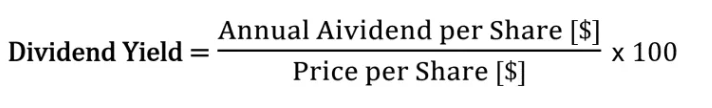
Reference : https://www.dividendinvestor.com/dividend-yield/
##### * use stock price on execution date as price per share

### Step 1: Left outer join using SQL query
Left join tables daily_stock and df (dividend information) on stock code and dividend execution date to get the stock price on execution date

In [37]:
# Connect to database
conn_string = 'postgresql://postgres:%s@localhost/dividend_investing_no2'% quote('@SMWHot4')

# Connect
db = create_engine(conn_string)
conn = db.connect()
conn = psycopg2.connect(conn_string)
conn.autocommit = True
cursor = conn.cursor()

# Using sql query to get recent date
sql2 ='''SELECT dividend_info."div_announced_year",dividend_info."div_financial_year",
dividend_info."div_subject",dividend_info."div_ex_date",dividend_info."div_payment_date"
,dividend_info."div_dividend(RM)"
,dividend_info."div_indicator",dividend_info."div_stock_code",dividend_info."div_year",
dividend_info."div_status",daily_stock."stock_date",daily_stock."stock_code",
daily_stock."stock_close"
FROM dividend_info  LEFT JOIN daily_stock  
ON (dividend_info."div_stock_code"=daily_stock."stock_code" AND dividend_info."div_ex_date"=daily_stock."stock_date")
ORDER BY dividend_info."div_ex_date";'''
cursor.execute(sql2)
daily_stock = cursor.fetchall()

df = pd.DataFrame(daily_stock, columns =["div_announced_year","div_financial_year","div_subject","div_ex_date",
                                         "div_payment_date","div_dividend(RM)","div_indicator","div_stock_code",
                                         "div_year","div_status","stock_date","stock_code","stock_close"])
conn.commit()
conn.close()

In [38]:
df

,div_announced_year,div_financial_year,div_subject,div_ex_date,div_payment_date,div_dividend(RM),div_indicator,div_stock_code,div_year,div_status,stock_date,stock_code,stock_close
0,2017-06-14,2018-01-31,First Interim Dividend,2017-06-30,2017-07-14,0.030,Currency,6399,2018,Y,2017-06-30,6399,1.781
1,2017-06-20,2018-04-30,Interim Dividend,2017-07-05,2017-07-28,0.015,Currency,7235,2018,Y,2017-07-05,7235,1.925
2,2017-07-04,2018-03-31,Interim Dividend,2017-07-14,2017-07-28,0.010,Currency,5267,2018,Y,2017-07-14,5267,1.208
3,2017-07-13,2018-02-28,First Interim Dividend,2017-07-27,2017-08-23,0.060,Currency,7048,2018,Y,2017-07-27,7048,3.519
4,2017-08-10,2018-03-31,Interim Dividend,2017-08-23,2017-09-08,0.020,Currency,0035,2018,Y,2017-08-23,0035,0.568
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5794,NaT,NaT,None,NaT,NaT,0.000,None,0169,2020,N,NaT,None,NaN
5795,NaT,NaT,None,NaT,NaT,0.000,None,0169,2019,N,NaT,None,NaN
5796,NaT,NaT,None,NaT,NaT,0.000,None,0169,2018,N,NaT,None,NaN
5797,NaT,NaT,None,NaT,NaT,0.000,None,7181,2019,N,NaT,None,NaN


### Step2:  Delete unnecessary columns

In [39]:
# Delete unnecessary columns
del df['div_subject']
del df['div_payment_date']
del df['div_indicator']
del df['stock_code']
del df['stock_date']
del df['div_financial_year']

In [40]:
df

,div_announced_year,div_ex_date,div_dividend(RM),div_stock_code,div_year,div_status,stock_close
0,2017-06-14,2017-06-30,0.030,6399,2018,Y,1.781
1,2017-06-20,2017-07-05,0.015,7235,2018,Y,1.925
2,2017-07-04,2017-07-14,0.010,5267,2018,Y,1.208
3,2017-07-13,2017-07-27,0.060,7048,2018,Y,3.519
4,2017-08-10,2017-08-23,0.020,0035,2018,Y,0.568
...,...,...,...,...,...,...,...
5794,NaT,NaT,0.000,0169,2020,N,NaN
5795,NaT,NaT,0.000,0169,2019,N,NaN
5796,NaT,NaT,0.000,0169,2018,N,NaN
5797,NaT,NaT,0.000,7181,2019,N,NaN


In [41]:
df.dtypes

div_announced_year    datetime64[ns]
div_ex_date           datetime64[ns]
div_dividend(RM)             float64
div_stock_code                object
div_year                      object
div_status                    object
stock_close                  float64
dtype: object

### Step 3: Calculate dividend yield 

In [42]:
df['dividend_y_%']=(df['div_dividend(RM)']/df['stock_close'])*100

In [43]:
df

,div_announced_year,div_ex_date,div_dividend(RM),div_stock_code,div_year,div_status,stock_close,dividend_y_%
0,2017-06-14,2017-06-30,0.030,6399,2018,Y,1.781,1.684447
1,2017-06-20,2017-07-05,0.015,7235,2018,Y,1.925,0.779221
2,2017-07-04,2017-07-14,0.010,5267,2018,Y,1.208,0.827815
3,2017-07-13,2017-07-27,0.060,7048,2018,Y,3.519,1.705030
4,2017-08-10,2017-08-23,0.020,0035,2018,Y,0.568,3.521127
...,...,...,...,...,...,...,...,...
5794,NaT,NaT,0.000,0169,2020,N,NaN,NaN
5795,NaT,NaT,0.000,0169,2019,N,NaN,NaN
5796,NaT,NaT,0.000,0169,2018,N,NaN,NaN
5797,NaT,NaT,0.000,7181,2019,N,NaN,NaN


### Step 4: Sum dividend yield and dividend  by year/annually

In [44]:
fun={'dividend_y_%':'sum','div_dividend(RM)':'sum'}
annual_div_info=df.groupby(['div_stock_code','div_year','div_status']).agg(fun)
annual_div_info.head(10)

dividend_y_%  div_dividend(RM)
div_stock_code div_year div_status                                
0001           2018     Y               1.650165             0.015
               2019     Y               1.159196             0.015
               2020     Y               0.970874             0.015
               2021     Y               1.342883             0.015
               2022     Y               0.282486             0.005
0002           2018     Y               3.395788             0.050
               2019     Y               4.305030             0.074
               2020     Y               3.847098             0.090
               2021     Y               3.166491             0.090
               2022     Y               5.417977             0.255

In [45]:
# Reset the index
annual_div_info= annual_div_info.reset_index()

In [46]:
annual_div_info

,div_stock_code,div_year,div_status,dividend_y_%,div_dividend(RM)
0,0001,2018,Y,1.650165,0.0150
1,0001,2019,Y,1.159196,0.0150
2,0001,2020,Y,0.970874,0.0150
3,0001,2021,Y,1.342883,0.0150
4,0001,2022,Y,0.282486,0.0050
...,...,...,...,...,...
3951,9962,2020,Y,2.100840,0.0050
3952,9962,2021,Y,3.361582,0.0100
3953,9962,2022,Y,1.754386,0.0050
3954,9997,2021,Y,3.715739,0.0225


In [47]:
# Round the dividend yield 
annual_div_info['dividend_y_%']=annual_div_info['dividend_y_%'].round(3)

In [48]:
annual_div_info

,div_stock_code,div_year,div_status,dividend_y_%,div_dividend(RM)
0,0001,2018,Y,1.650,0.0150
1,0001,2019,Y,1.159,0.0150
2,0001,2020,Y,0.971,0.0150
3,0001,2021,Y,1.343,0.0150
4,0001,2022,Y,0.282,0.0050
...,...,...,...,...,...
3951,9962,2020,Y,2.101,0.0050
3952,9962,2021,Y,3.362,0.0100
3953,9962,2022,Y,1.754,0.0050
3954,9997,2021,Y,3.716,0.0225


# Load the data into database

In [51]:
conn_string = 'postgresql://postgres:%s@localhost/dividend_investing_no2'% quote('@SMWHot4')
db = create_engine(conn_string)
conn = db.connect()

In [52]:
annual_div_info.to_sql('annual_div_info', con=conn, if_exists='replace',
          index=False)
conn = psycopg2.connect(conn_string
                        )
conn.autocommit = True
cursor = conn.cursor()

sql1 = '''select * from annual_div_info;'''
cursor.execute(sql1)
for i in cursor.fetchall():
    print(i)

conn.commit()
conn.close()

('0001', '2018', 'Y', 1.65, 0.015)
('0001', '2019', 'Y', 1.159, 0.015)
('0001', '2020', 'Y', 0.971, 0.015)
('0001', '2021', 'Y', 1.343, 0.015)
('0001', '2022', 'Y', 0.282, 0.005)
('0002', '2018', 'Y', 3.396, 0.05)
('0002', '2019', 'Y', 4.305, 0.074)
('0002', '2020', 'Y', 3.847, 0.09)
('0002', '2021', 'Y', 3.166, 0.09000000000000001)
('0002', '2022', 'Y', 5.418, 0.255)
('0005', '2018', 'N', 0.0, 0.0)
('0005', '2019', 'N', 0.0, 0.0)
('0005', '2020', 'N', 0.0, 0.0)
('0005', '2021', 'N', 0.0, 0.0)
('0005', '2022', 'N', 0.0, 0.0)
('0006', '2018', 'N', 0.0, 0.0)
('0006', '2019', 'N', 0.0, 0.0)
('0006', '2020', 'N', 0.0, 0.0)
('0006', '2021', 'N', 0.0, 0.0)
('0006', '2022', 'N', 0.0, 0.0)
('0007', '2018', 'N', 0.0, 0.0)
('0007', '2019', 'N', 0.0, 0.0)
('0007', '2020', 'N', 0.0, 0.0)
('0007', '2021', 'N', 0.0, 0.0)
('0007', '2022', 'N', 0.0, 0.0)
('0008', '2018', 'Y', 2.445, 0.01)
('0008', '2019', 'Y', 3.24, 0.015)
('0008', '2020', 'Y', 3.024, 0.015)
('0008', '2021', 'Y', 3.846, 0.015)
('0010'